![](img/330-banner.png)

# (Optional)<br>Lecture 23: Stochastic Gradient Descent (SGD)

UBC 2024 Summer

Instructor: Mehrdad Oveisi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

plt.rcParams['font.size'] = 16

## For large datasets: `SGDClassifier` and `SGDRegressor`

***Note*** 
Although we speak of very large datasets here, we do *not* mean what has come to be known as *Big Data*. Some say the realm of Big Data starts with at least *1 terabyte* of data! We do not discuss the requirements for handling such datasets here.

- Something we haven't discussed in this course is large data sets.
- There could be a couple of problems arising from large data sets:
  1. The code is too slow.
  2. The dataset doesn't fit in memory - we can't even load it with `pd.read_csv`. 

Simplest strategy: subset your data for experimentation / hyperparameter tuning, then train your final model on the whole dataset (once).

- "SGD" (stochastic gradient descent) can help with both of these problems.
- But we'll focus on using it to solve problem (1).
- There is a fancy way to implement `fit` that can be a lot faster for large datasets.
  - You can **think of it as quickly finding "approximately" the best coefficients** when calling `fit`.
  - That is not quite true but it may be a useful way of thinking.
  - Much more on this in CPSC 340 and much, much more on this in CPSC 440/540.

- SGD can be used in many contexts.
- In sklearn, it's built in as follows:

In [2]:
from sklearn.linear_model import SGDClassifier, SGDRegressor

- `SGDRegressor` is basically equivalent to `Ridge`.
- `SGDRegressor(loss='huber')` is basically equivalent to `HuberRegressor`.
- `SGDClassifier(loss='log_loss')` is basically equivalent to `LogisticRegression`, except the parameter is called `alpha` instead of `C` (like `Ridge`).
- With other settings they are equivalent to other models, but this is good enough.

- For **regular sized** datasets, use the **original functions**, as these ones can be a bit more finicky. 

Let's load the [Sentiment140 dataset](http://help.sentiment140.com/home), which contains tweets labeled with sentiment associated with a brand, product, or topic. It is a large dataset. You can download the data from [here](https://www.kaggle.com/ferno2/training1600000processednoemoticoncsv).

In [3]:
tweets_df = pd.read_csv('../data/training.1600000.processed.noemoticon.csv', 
                        encoding = "ISO-8859-1",
                        names=["label", "id", "date", "no_query", "name", "text"])
tweets_df['label'] = tweets_df['label'].map({0: 'neg', 4: 'pos'})
tweets_df = tweets_df[tweets_df['label'].str.startswith(('pos','neg'))]

In [4]:
tweets_df_train, tweets_df_test = train_test_split(tweets_df)

In [5]:
tweets_df_train.head()

,label,id,date,no_query,name,text
454140,neg,2070518086,Sun Jun 07 17:50:14 PDT 2009,NO_QUERY,DylanCullen,@WerewolfLeah @WereWolf_Embry *runs and hugs y...
383354,neg,2053179608,Sat Jun 06 03:35:10 PDT 2009,NO_QUERY,davidelrizzo,@maddisondesigns - let me know if Terminator i...
492672,neg,2184354708,Mon Jun 15 15:47:17 PDT 2009,NO_QUERY,brittblevins,hmm nothig to do! At this point just messing ...
1129635,pos,1975566665,Sat May 30 15:25:51 PDT 2009,NO_QUERY,vkmenno,@fiederels that's my girl!
722700,neg,2261567636,Sat Jun 20 20:59:44 PDT 2009,NO_QUERY,alwayswithjoe,"I go to sleep, because i'm veeeeeeeeeeeeery ve..."


In [6]:
tweets_df_train.shape

(1200000, 6)

Holy cow!

In [7]:
vec = CountVectorizer(stop_words='english')

X_train = vec.fit_transform(tweets_df_train['text']) 
y_train = tweets_df_train['label']

X_test = vec.transform(tweets_df_test['text']) 
y_test = tweets_df_test['label']

In [8]:
X_train.shape

(1200000, 563728)

In [9]:
type(X_train)

scipy.sparse._csr.csr_matrix

Here is the **fraction of elements that are nonzero**, showing that having a sparse matrix really helps!!

In [10]:
X_train.nnz / np.prod(X_train.shape)

1.23448823427847e-05

Now let's train a classifier. I'll use `%time` instead of `%timeit` because I want to keep the output, and it gets lost with `%timeit`.

In [11]:
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_train, y_train)

0.5000808333333333

In [12]:
lr = LogisticRegression()

In [13]:
%time lr.fit(X_train, y_train);

CPU times: user 4min 2s, sys: 2min 57s, total: 6min 59s
Wall time: 1min 9s


/home/mehrdad/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In `LogisticRegression`, the hyperparameter `max_iter` is set to 100 by default. We could increase it to get rid of this warning, but it would then take even longer to run `fit()`.

In [14]:
lr.score(X_train, y_train)

0.808785

In [15]:
lr.score(X_test, y_test)

0.777515

In [16]:
lr.n_iter_

array([100], dtype=int32)

Now, let's try to use `SGDClassifier` on the same data:

In [17]:
lr_sgd = SGDClassifier(loss="log_loss")

In [18]:
%time lr_sgd.fit(X_train, y_train);

CPU times: user 5.73 s, sys: 451 ms, total: 6.18 s
Wall time: 5.23 s


In [19]:
lr_sgd.n_iter_

7

In [20]:
lr_sgd.score(X_train, y_train)

0.7694141666666666

In [21]:
lr_sgd.score(X_test, y_test)

0.7654175

- `SGDClassifier` was **many folds faster** than `LogisticRegression`, but the accuracy is slightly lower.
- In fact, we can control the speed vs. _train_ accuracy tradeoff in both cases using the hyperparameters.
  - The main ones are `max_iter` (higher is slower) and/or `tol` (lower is slower)
  - (This is the same for both `LogisticRegression` and `SGDClassifier`)
  - This is analogous to `n_iter` in `RandomizedSearchCV` !
- In general, `LogisticRegression` will get slightly higher _train_ accuracy (may or may not correspond to better validation/test)
- But in some cases your **dataset is so big** that `LogisticRegression` is **not feasible**, and then `SGDClassifier` can save the day.

In [22]:
# from https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_early_stopping.html#sphx-glr-auto-examples-linear-model-plot-sgd-early-stopping-py

# from sklearn.utils._testing import ignore_warnings
# from sklearn.exceptions import ConvergenceWarning

# @ignore_warnings(category=ConvergenceWarning)
def fit_grid_search_lr(iters):
    grid_search_lr = GridSearchCV(
        LogisticRegression(), 
        {"max_iter" : iters}, return_train_score=True, verbose=2, cv=2, n_jobs=-1)
    # n_jobs=-1 might mess up the timing a bit but otherwise it takes too long
    grid_search_lr.fit(X_train, y_train)
    return grid_search_lr

grid_search_lr = fit_grid_search_lr([3, 10, 30, 100])

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/home/mehrdad/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mehrdad/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [23]:
results_lr = pd.DataFrame(grid_search_lr.cv_results_)
results_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,13.434878,0.966732,6.315260,0.697648,3,{'max_iter': 3},0.680562,0.677720,0.679141,0.001421,4,0.680717,0.678533,0.679625,0.001092
1,18.073809,5.166639,6.377006,0.754571,10,{'max_iter': 10},0.752637,0.752838,0.752738,0.000101,3,0.755217,0.755710,0.755463,0.000247
2,29.596003,1.123890,5.238160,0.606483,30,{'max_iter': 30},0.770370,0.770185,0.770277,0.000092,2,0.782932,0.783305,0.783118,0.000187
3,51.485675,0.774465,2.334501,0.313812,100,{'max_iter': 100},0.772608,0.771058,0.771833,0.000775,1,0.829998,0.828507,0.829252,0.000746


In [24]:
grid_search_sgd = GridSearchCV(
    SGDClassifier(loss="log_loss", max_iter=100_000),
    {"tol" : [1e-3, 1e-4, 1e-5]},
    return_train_score=True, verbose=2, cv=2, n_jobs=-1)

grid_search_sgd.fit(X_train, y_train);

Fitting 2 folds for each of 3 candidates, totalling 6 fits


In [25]:
results_sgd = pd.DataFrame(grid_search_sgd.cv_results_)
results_sgd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,10.120389,0.571758,6.163771,0.018427,0.001,{'tol': 0.001},0.764958,0.765627,0.765292,0.000334,3,0.771648,0.772955,0.772302,0.000653
1,16.190669,0.636387,7.436611,0.012156,0.0001,{'tol': 0.0001},0.765375,0.765512,0.765443,0.000068,2,0.772363,0.772995,0.772679,0.000316
2,30.598734,1.042168,2.492567,0.242175,0.00001,{'tol': 1e-05},0.765488,0.765627,0.765558,0.000069,1,0.772347,0.773215,0.772781,0.000434


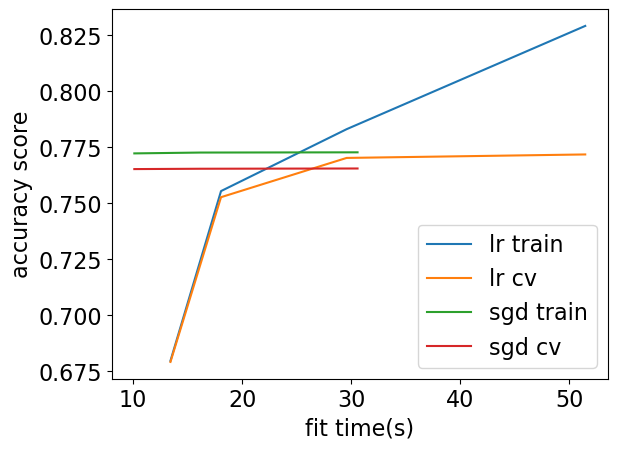

In [26]:
plt.plot(results_lr["mean_fit_time"], results_lr["mean_train_score"], label="lr train")
plt.plot(results_lr["mean_fit_time"], results_lr["mean_test_score"], label="lr cv")
plt.plot(results_sgd["mean_fit_time"], results_sgd["mean_train_score"], label="sgd train")
plt.plot(results_sgd["mean_fit_time"], results_sgd["mean_test_score"], label="sgd cv")
plt.xlabel("fit time(s)");
plt.ylabel("accuracy score");
plt.legend();

<br><br>

TL;DR if you don't want to wait that long, `SGDClassifier` will probably do better on a large dataset.